In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    Dropout,
    Flatten,
    Dense,
    Reshape,
    GlobalAveragePooling2D,
)

In [ ]:
import os
import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
    return images


def resize_and_normalize_image(img, target_size):
    # Maintain aspect ratio and add padding
    old_size = img.shape[:2]  # old_size is in (height, width) format
    ratio = float(target_size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    resized_img = cv2.resize(
        img, (new_size[1], new_size[0])
    )  # resize() requires (width, height)

    delta_w = target_size[1] - new_size[1]
    delta_h = target_size[0] - new_size[0]

    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(
        resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )

    normalized_img = new_img / 255.0  # Normalize pixel values
    return normalized_img


def resize_and_normalize_images(images, target_size):
    with ThreadPoolExecutor() as executor:
        resized_images = list(
            executor.map(
                lambda img: resize_and_normalize_image(img, target_size), images
            )
        )
    return np.array(resized_images)


train_folder = (
    r"C:\Users\kunjf\Documents\AI Saksham\Image Compression\data2\train_images"
)
test_folder = r"C:\Users\kunjf\Documents\AI Saksham\Image Compression\data2\test_images"
save_path = r"C:\Users\kunjf\Documents\AI Saksham\Image Compression\data2"
target_size = (128, 128)  # Set your desired target size for images

train_images = load_images_from_folder(train_folder)
test_images = load_images_from_folder(test_folder)

X_train = resize_and_normalize_images(train_images, target_size)
X_test = resize_and_normalize_images(test_images, target_size)

np.save(os.path.join(save_path, "X_train2.npy"), X_train)
np.save(os.path.join(save_path, "X_test2.npy"), X_test)

In [5]:
def build_flexible_autoencoder():
    input_img = Input(
        shape=input_shape
    )  # Input shape determined by your maximum image size

    # # Encoder
    # x = Conv2D(128, (3, 3), activation="relu", padding="same")(input_img)
    # x = MaxPooling2D((2, 2), padding="same")(x)
    # x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    # x = MaxPooling2D((2, 2), padding="same")(x)
    # x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    # encoded = MaxPooling2D((2, 2), padding="same")(x)
    # # Decoder
    # x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoded)
    # x = UpSampling2D((2, 2))(x)
    # x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    # x = UpSampling2D((2, 2))(x)
    # x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    # x = UpSampling2D((2, 2))(x)
    # decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    # autoencoder = Model(input_img, decoded)
    # return autoencoder


# Define input shape
input_shape = (None, None, 3)  # Dynamic input shape


def build_flexible_autoencoder():
    input_img = Input(shape=(None, None, 3))

    # Encoder
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(input_img)
    x = MaxPooling2D((2, 2), padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    encoded = MaxPooling2D((2, 2), padding="same")(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [6]:
autoencoder = build_flexible_autoencoder()
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None,     │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 64) │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None, 32) │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None, 32) │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, None, 3)  │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,899 (784.76 KB)

 Trainable params: 200,899 (784.76 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
import numpy as np

# Load the data from the saved files
X_train = np.load(
    r"C:\Kunj\Programming\AI Saksham\Image Compression\data2\X_train_64.npy"
)
X_test = np.load(
    r"C:\Kunj\Programming\AI Saksham\Image Compression\data2\X_test_64.npy"
)

In [8]:
autoencoder.fit(
    X_train, X_train, epochs=15, batch_size=8, validation_data=(X_test, X_test)
)

Epoch 1/15
 59/500 ━━━━━━━━━━━━━━━━━━━━ 4:02 549ms/step - loss: 0.0785

KeyboardInterrupt: 

In [ ]:
autoencoder.save("color_128.h5")

In [4]:
from keras.models import load_model

model_color = load_model("color_128.h5")

In [5]:
# Predict and display results
pred = model_color.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


In [6]:
from PIL import Image

Original Image Shape: (640, 427)
Processed Image Shape: (427, 640, 3)
Model Input Shape: (None, None, None, 3)
Input Image Shape for Prediction: (1, 427, 640, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted Image Shape: (1, 432, 640, 3)


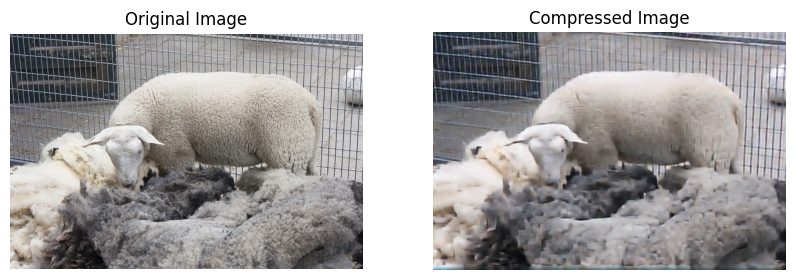

In [7]:
# Load your color image
image_path = "data2/train_images/image_89.png"
image = Image.open(image_path)
print("Original Image Shape:", image.size)

# Ensure the image is in RGB format
image = image.convert("RGB")  # Resize and convert to RGB
image = np.array(image) / 255.0
print("Processed Image Shape:", image.shape)
print("Model Input Shape:", model_color.input_shape)

# Reshape and predict
input_image = np.expand_dims(image, axis=0)
print("Input Image Shape for Prediction:", input_image.shape)

predicted_image = model_color.predict(input_image)
print("Predicted Image Shape:", predicted_image.shape)

# Display original and compressed images
plt.figure(figsize=(10, 4))

# Display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Display compressed image
ax = plt.subplot(1, 2, 2)
plt.imshow(predicted_image[0])
plt.title("Compressed Image")
plt.axis("off")

plt.show()

Original Image Shape: (2000, 600)
Processed Image Shape: (450, 1500, 3)
Model Input Shape: (None, None, None, 3)
Input Image Shape for Prediction: (1, 450, 1500, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step
Predicted Image Shape: (1, 456, 1504, 3)


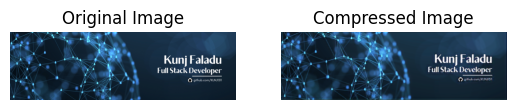

In [8]:
# Example usage:
image_path = "kunj.png"
image = Image.open(image_path)
print("Original Image Shape:", image.size)

# Ensure the image is in RGB format
image = image.convert("RGB")  # Resize and convert to RGB
image = np.array(image) / 255.0
# Get the dimensions of the image
height, width, channels = image.shape

resized_image = image
# Check if either height or width is greater than 1000
if height > 1500 or width > 1500:
    # Calculate the aspect ratio
    aspect_ratio = width / height

    # Calculate the new dimensions
    new_width = min(width, 1500)
    new_height = int(new_width / aspect_ratio)

    # Resize the image while maintaining aspect ratio
    resized_image = cv2.resize(image, (new_width, new_height))

    # Check if the new height exceeds 1000
    if new_height > 1500:
        # Calculate the final dimensions
        final_height = 1500
        final_width = int(final_height * aspect_ratio)

        # Resize the image to final dimensions
        resized_image = cv2.resize(resized_image, (final_width, final_height))

print("Processed Image Shape:", resized_image.shape)
print("Model Input Shape:", model_color.input_shape)

# Reshape and predict
input_image = np.expand_dims(resized_image, axis=0)
print("Input Image Shape for Prediction:", input_image.shape)

predicted_image = model_color.predict(input_image)
print("Predicted Image Shape:", predicted_image.shape)


# Display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(resized_image)
plt.title("Original Image")
plt.axis("off")

# Display compressed image
ax = plt.subplot(1, 2, 2)
plt.imshow(predicted_image[0])
plt.title("Compressed Image")
plt.axis("off")

plt.show()

In [10]:
# Scale the pixel values back to the original range (0-255) for uint8 format
compressed_img_uint8 = (predicted_image[0] * 255).astype(np.uint8)

# Save the compressed image
cv2.imwrite(
    "compressed_image_128.jpg",
    cv2.cvtColor(compressed_img_uint8, cv2.COLOR_RGB2BGR),
)

True